In [1]:
import pandas as pd
import numpy as np
import math
daf=pd.read_csv("D:/LSE/revision 2021/DS project/uttn/business_info.csv",low_memory=False)

In [2]:
daf1=daf[["business_id","city","latitude","longitude"]]
daft=daf1[daf1['city']=="Toronto"]
daft=daft[["business_id","latitude","longitude"]]
dafp=daf1[daf1['city']=="Phoenix"]
dafp=dafp[["business_id","latitude","longitude"]]
def rong(city):
    return([[max(city['latitude']),min(city['latitude'])],[max(city['longitude']),min(city['longitude'])]])
l=rong(dafp)


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

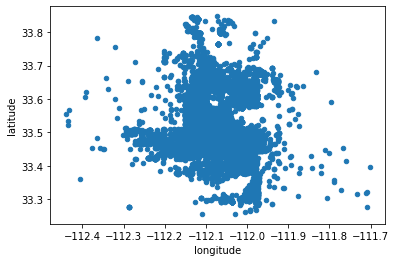

In [27]:
import matplotlib.pyplot as plt
dafp.plot.scatter(y="latitude", x="longitude")

In [4]:
import statistics as st
def mv(city):
    return([[st.mean(city['longitude']),st.variance(city['longitude'])],[st.mean(city['latitude']),st.variance(city['latitude'])]])
s=mv(dafp)

print(s)

[[-112.06093269501132, 0.004068166898922104], [33.52770371476082, 0.010382646599758844]]


In [5]:
n=5
def get_randphi(n):
    h=[]
    for i in range(n-1):
        a=np.random.uniform(0,((i+2)/n)-sum(h))
        h.append(a)
    h.append(1-sum(h))
    return(h)
def get_randmu(s,n):
    mu=[]
    for i in range(n):
        mu.append(np.array([np.random.normal(s[0][0],s[0][1]),np.random.normal(s[1][0],s[1][1])]))
    return mu

def get_random_psd(s):
    x = np.random.normal(0, math.sqrt(s[0][1]), size=(2, 2))
    return np.dot(x, x.transpose())
def get_randomsig(df,n):
    sigma=[]
    for i in range(n):
        sigma.append(get_random_psd(df))
    return sigma
def initialize_random_params(df,n):
    s=mv(df)
    params = {'phi': get_randphi(n),
              'mu': get_randmu(s,n),
              'sigma': get_randomsig(s,n)}
    return params

In [6]:
params=initialize_random_params(dafp,2)
print(params)
from scipy import stats
from scipy.special import logsumexp
from sklearn.mixture import GaussianMixture
def e_step(x, params):
    n=len(params['phi'])    
    dist=[stats.multivariate_normal(params["mu"][i], params["sigma"][i]).pdf(x) for i in range(n)]       
    log_p_y_x = np.log(params['phi'])[np.newaxis, ...] + \
                np.log(dist).T
    log_p_y_x_norm = logsumexp(log_p_y_x, axis=1)
    return log_p_y_x_norm, np.exp(log_p_y_x - log_p_y_x_norm[..., np.newaxis])

{'phi': [0.8700296834063467, 0.12997031659365332], 'mu': [array([-112.06356791,   33.52350696]), array([-112.06457422,   33.52352958])], 'sigma': [array([[ 0.00499561, -0.00334591],
       [-0.00334591,  0.01530612]]), array([[ 0.00679187, -0.00266601],
       [-0.00266601,  0.00995242]])]}


In [7]:
def m_step(x, params):
    n=len(params['phi'])
    total_count = x.shape[0]
    _, heurs = e_step(x, params)
    heuristics=[heurs[:,i] for i in range(n)]
    sum_heuristics = [np.sum(heuristic) for heuristic in heuristics]
    phi = [sum_heuristic/total_count for sum_heuristic in sum_heuristics]
    mu=[(heuristics[i][..., np.newaxis].T.dot(x)/sum_heuristics[i]).flatten() for i in range(n)]
    diff=[x-m for m in mu]
    sigma = [diff[i].T.dot(diff[i] * heuristics[i][..., np.newaxis])/sum_heuristics[i] for i in range(n)]
    params = {'phi': phi, 'mu' : mu, 'sigma': sigma}
    return params

In [9]:
d=dafp[['longitude','latitude']]

l=m_step(d,params)

In [68]:
def get_avg_log_likelihood(x, params):
    loglikelihood, _ = e_step(x, params)
    return np.mean(loglikelihood)


def run_em(x,n):
    params=initialize_random_params(x,n)
    avg_loglikelihoods = []
    while True:
        avg_loglikelihood = get_avg_log_likelihood(x, params)
        avg_loglikelihoods.append(avg_loglikelihood)
        if len(avg_loglikelihoods) > 2 and abs(avg_loglikelihoods[-1] - avg_loglikelihoods[-2]) < 0.000001:
            break
        params = m_step(x, params)
    _, posterior = e_step(x, params)
    forecasts = np.argmax(posterior, axis=1)
    return params, forecasts, posterior, avg_loglikelihoods

def REM(df,cols,n):
    d=df[cols]
    return run_em(d,n)

In [25]:
print(run_em(d,4))

	phi: [0.4734224027748096, 0.3043735964028311, 0.1673856157772581, 0.05481838504510109]
	mu: [array([-112.05669932,   33.5190353 ]), array([-112.07755584,   33.57290286]), array([-112.03879207,   33.49503517]), array([-112.07280004,   33.45135415])]
	sigma: [           longitude  latitude
longitude   0.002874 -0.003788
latitude   -0.003788  0.015858,            longitude  latitude
longitude   0.007469  0.004621
latitude    0.004621  0.005500,            longitude  latitude
longitude   0.001498 -0.000118
latitude   -0.000118  0.000262,            longitude  latitude
longitude   0.000013  0.000005
latitude    0.000005  0.000021]
(array([1, 1, 0, ..., 0, 2, 1], dtype=int32), array([[3.55452471e-001, 6.44547529e-001, 7.90945929e-017,
        0.00000000e+000],
       [1.86803802e-001, 8.13196198e-001, 4.02495131e-011,
        1.67733777e-291],
       [7.08982638e-001, 3.75586457e-002, 2.52071103e-001,
        1.38761271e-003],
       ...,
       [8.44763111e-001, 1.55236889e-001, 1.97192346

In [33]:
x_unlabeled = d

# Unsupervised learning
print("unsupervised: ")
random_params = initialize_random_params(dafp,n)
params,unsupervised_forecastsforecasts, unsupervised_posterior, unsupervised_loglikelihoods = run_em(d,3)
print("total steps: ", len(unsupervised_loglikelihoods))
plt.plot(unsupervised_loglikelihoods)
plt.title("unsupervised log likelihoods")
plt.savefig("unsupervised.png")
plt.close()

unsupervised: 
	phi: [0.6878118410785266, 0.13189953917001052, 0.18028861975146293]
	mu: [array([-112.05214244,   33.53777172]), array([-112.05876218,   33.44337566]), array([-112.096056  ,   33.55098825])]
	sigma: [           longitude  latitude
longitude   0.002640 -0.001627
latitude   -0.001627  0.010536,            longitude  latitude
longitude   0.002146 -0.003766
latitude   -0.003766  0.007076,            longitude  latitude
longitude   0.009392  0.005561
latitude    0.005561  0.006082]
total steps:  49


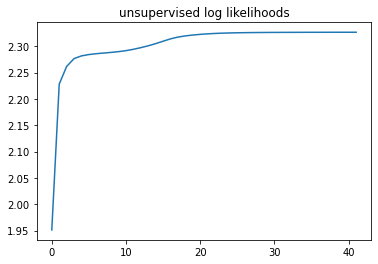

In [30]:
plt.plot(unsupervised_loglikelihoods)
plt.title("unsupervised log likelihoods")
plt.savefig("unsupervised.png")


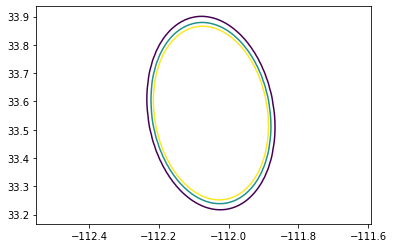

In [64]:
from scipy.stats import multivariate_normal as mvn
params,unsupervised_forecastsforecasts, unsupervised_posterior, unsupervised_loglikelihoods = run_em(d,3)

# Generate grid points
def gen_grid(df,a):
    ron=rong(df)
    men=[st.mean(ron[1]),st.mean(ron[0])]
    dest=[men[0]-ron[1][0],men[1]-ron[0][0]]
    
    x, y = np.meshgrid(np.linspace(men[0]-a*dest[0],men[0]+dest[0]*a,100),np.linspace(men[1]-a*dest[1],men[1]+dest[1]*a,100))
    return np.column_stack([x.flat, y.flat]),x,y


# density values at the grid points
r,X,Y=gen_grid(dafp,1.3)
Z = mvn.pdf(r, params['mu'][0], params['sigma'][0]).reshape(X.shape)

# arbitrary contour levels
contour_level = [0.1, 0.2, 0.3]

fig = plt.contour(X, Y, Z, levels = contour_level)

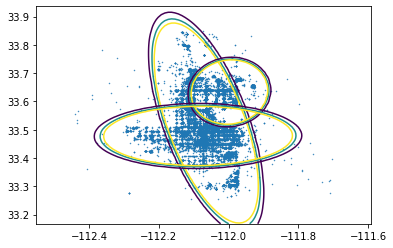

In [70]:
params,unsupervised_forecastsforecasts,unsupervised_posterior,unsupervised_loglikelihoods = REM(dafp,['longitude','latitude'],3)
for i in range(3):
    Z = mvn.pdf(r, params['mu'][i], params['sigma'][i]).reshape(X.shape)

    plt.contour(X, Y, Z, levels = contour_level)

plt.scatter(x=dafp.longitude,y=dafp.latitude,s=0.2)